### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from io import StringIO

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6
# new source https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74

In [4]:
req = requests.get(download_link)
data = StringIO(req.text)
rki_raw = pd.read_csv(StringIO(req.text))

In [5]:
rki_raw.tail()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,Landkreis ID,Datenstand,Neuer Fall,Neuer Todesfall,Referenzdatum,Neu Genesen,Anzahl Genesen
98120,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2506521,3/27/2020 12:00:00 AM,16077,"16.04.2020, 00:00 Uhr",0,-9,3/18/2020 12:00:00 AM,0,1
98121,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2506522,4/2/2020 12:00:00 AM,16077,"16.04.2020, 00:00 Uhr",0,-9,3/31/2020 12:00:00 AM,-9,0
98122,16,Thüringen,LK Altenburger Land,A60-A79,W,1,0,2506523,4/5/2020 12:00:00 AM,16077,"16.04.2020, 00:00 Uhr",0,-9,3/31/2020 12:00:00 AM,0,1
98123,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2506524,3/24/2020 12:00:00 AM,16077,"16.04.2020, 00:00 Uhr",0,-9,3/16/2020 12:00:00 AM,0,1
98124,16,Thüringen,LK Altenburger Land,A80+,M,1,0,2506525,3/27/2020 12:00:00 AM,16077,"16.04.2020, 00:00 Uhr",0,-9,3/23/2020 12:00:00 AM,0,1


In [6]:
def new_cases_by_date(rki_raw, rki_flag_column='Neuer Fall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Meldedatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [7]:
rki_cases = new_cases_by_date(rki_raw)
rki_death = new_cases_by_date(rki_raw, rki_flag_column='Neuer Todesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='Neu Genesen', rki_count_columns='Anzahl Genesen')

In [8]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeath', 'Anzahl Genesen': 'NewRecovered'}
rki.rename(columns_dict, axis=1, inplace=True)
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeath,NewRecovered
Meldedatum,,,
2020-04-11,2876,34.0,227.0
2020-04-12,1795,36.0,120.0
2020-04-13,1560,37.0,92.0
2020-04-14,2102,39.0,137.0
2020-04-15,1122,6.0,49.0


In [9]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,
2020-04-06,3651,141.0,1217.0,102661,3007.0,72826.0,29835.0,0.122373
2020-04-07,5084,132.0,1401.0,107745,3139.0,74227.0,33518.0,0.151680
2020-04-08,5205,122.0,1050.0,112950,3261.0,75277.0,37673.0,0.138163
2020-04-09,4822,104.0,774.0,117772,3365.0,76051.0,41721.0,0.115577
2020-04-10,3223,52.0,374.0,120995,3417.0,76425.0,44570.0,0.072313
2020-04-11,2876,34.0,227.0,123871,3451.0,76652.0,47219.0,0.060908
2020-04-12,1795,36.0,120.0,125666,3487.0,76772.0,48894.0,0.036712
2020-04-13,1560,37.0,92.0,127226,3524.0,76864.0,50362.0,0.030976
2020-04-14,2102,39.0,137.0,129328,3563.0,77001.0,52327.0,0.040170


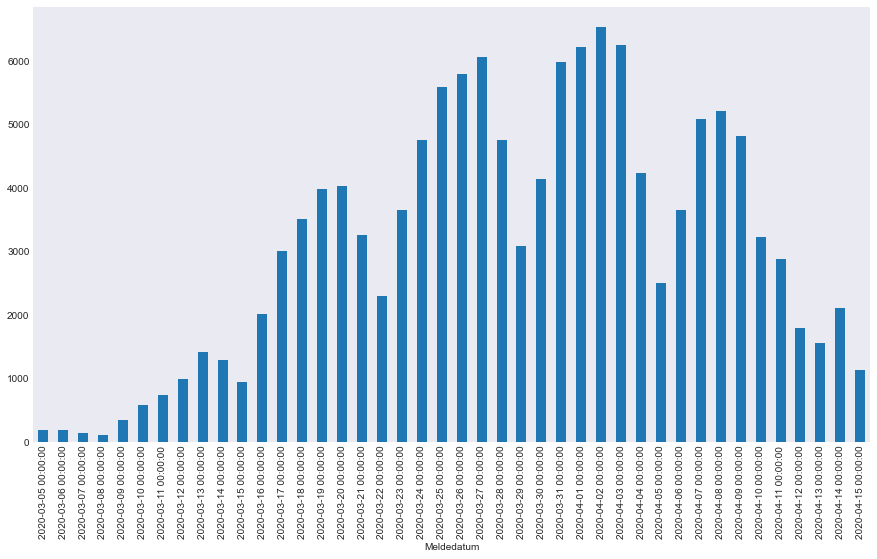

In [10]:
rki.NewCases['03-05-2020':].plot.bar()

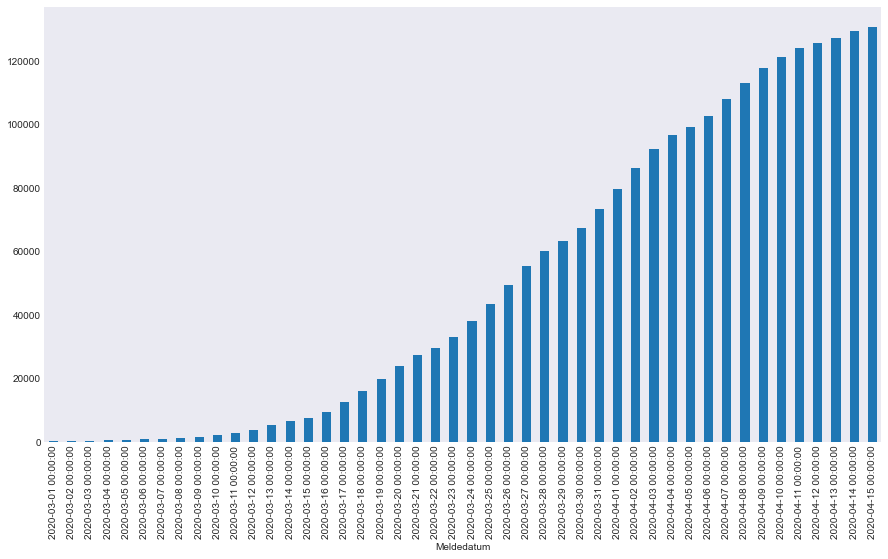

In [11]:
rki.Cases['03-01-2020':].plot.bar()

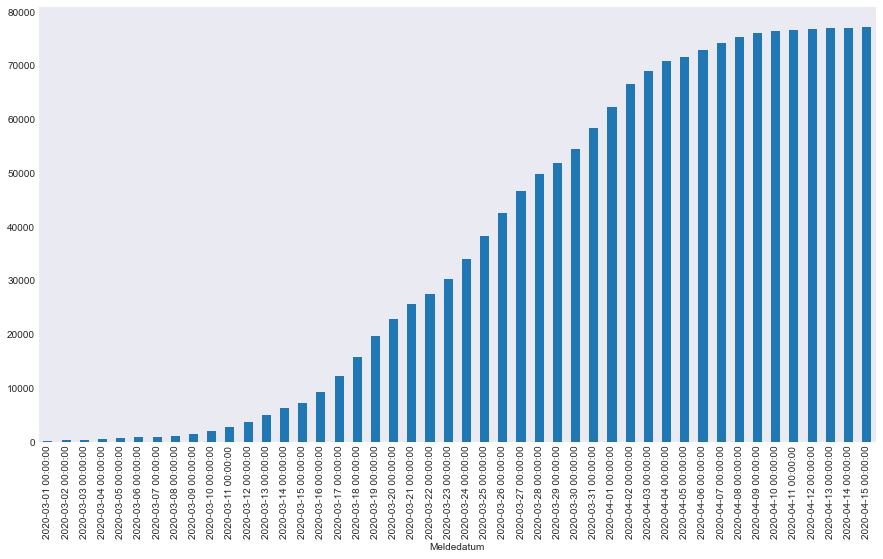

In [12]:
rki.Recovered['03-01-2020':].plot.bar()

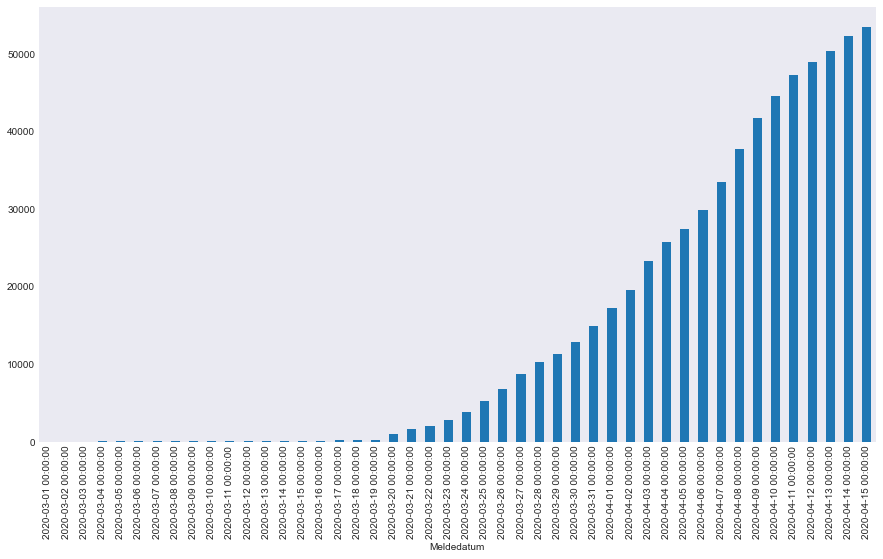

In [13]:
rki.ActiveCases['03-01-2020':].plot.bar()

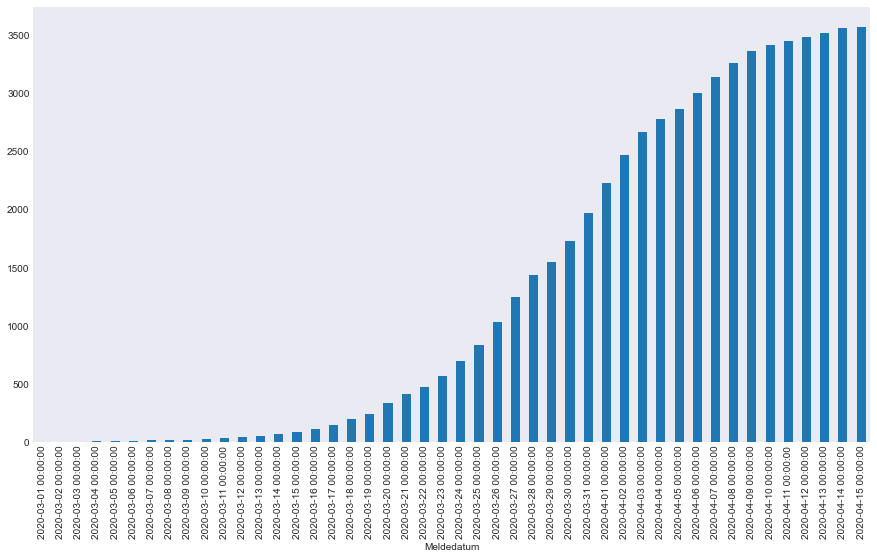

In [14]:
rki.Death['03-01-2020':].plot.bar()

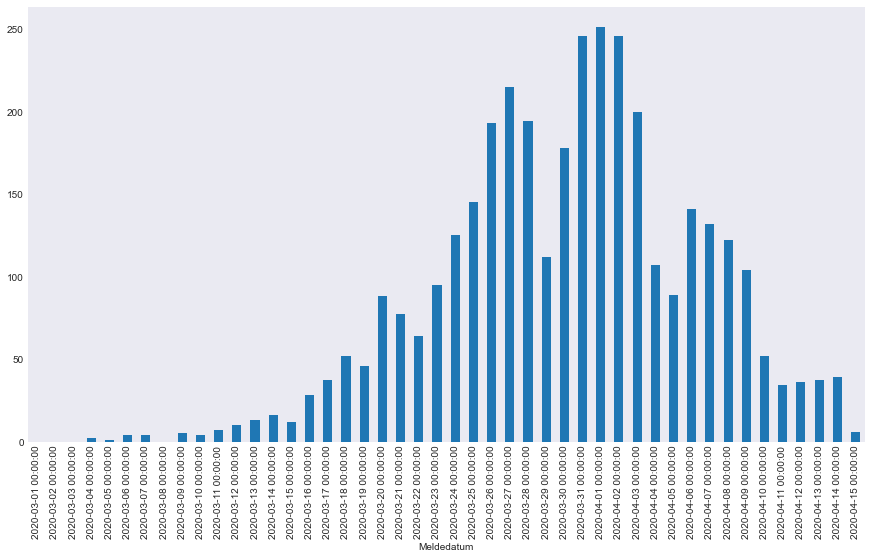

In [15]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

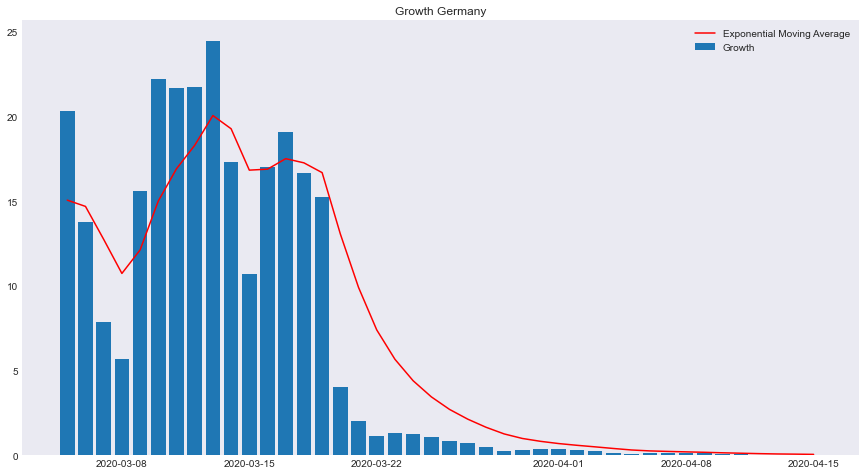

In [16]:
start_date = '03-05-2020'
x = rki[start_date:].index

plt.bar(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=6,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

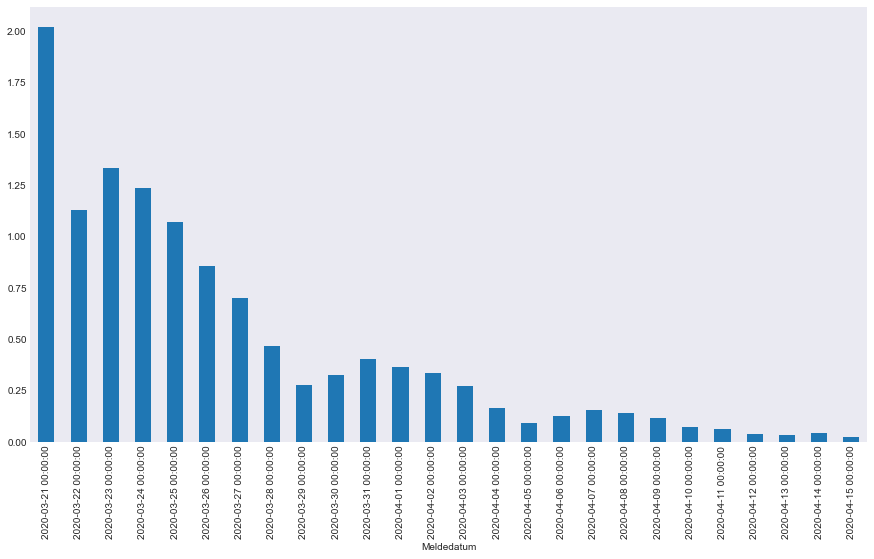

In [17]:
rki.Growth['03-21-2020':].plot.bar()

Text(0.5, 1.0, 'New Cases Germany')

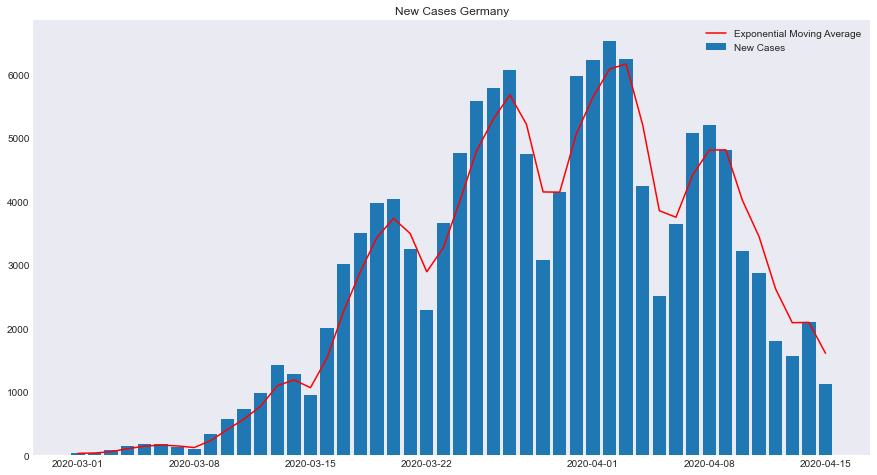

In [18]:
start_date = '03-01-2020'
x = rki[start_date:].index

plt.bar(x, rki.NewCases[start_date:], label='New Cases')
plt.plot(x, rki.NewCases.ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('New Cases Germany')

In [19]:
rki.tail(20)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,
2020-03-27,6071,215.0,4130.0,55277,1243.0,46569.0,8708.0,0.697175
2020-03-28,4755,194.0,3241.0,60032,1437.0,49810.0,10222.0,0.465173
2020-03-29,3086,112.0,2033.0,63118,1549.0,51843.0,11275.0,0.273703
2020-03-30,4146,178.0,2633.0,67264,1727.0,54476.0,12788.0,0.324210
2020-03-31,5987,246.0,3834.0,73251,1973.0,58310.0,14941.0,0.400709
2020-04-01,6226,251.0,3966.0,79477,2224.0,62276.0,17201.0,0.361956
2020-04-02,6531,246.0,4172.0,86008,2470.0,66448.0,19560.0,0.333896
2020-04-03,6254,200.0,2567.0,92262,2670.0,69015.0,23247.0,0.269024
2020-04-04,4241,107.0,1705.0,96503,2777.0,70720.0,25783.0,0.164488
